## IR LAB 1 - Kuba Czech 156035, Wojciech Nagórka 156045 ##

In this class, we will talk about model explainability but more in the context of data explainability or root cause analysis. In many cases building a very good machine learning model is not an ultimate goal. What is really wanted is the data understanding. A factory wants to know why the product is plagued with a defect, not to predict afterward if there is a defect or not. A football team wants to know which position is the best for scoring a goal, not what's the probability of scoring from a given position. And even when they want a prediction they would love to see the justification to trust the model. Often a nice plot is worth more than sophisticated machine-learning approaches.

In [18]:
import pandas as pd
import numpy as np
import dalex as dx
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [19]:
data = load_wine()

In [20]:
data
df = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']
df['target'] = y

You should already be familiar with many data visualization techniques so we will not train it now. I just want to share a less popular type of data analysis. Usually plotting the target against any feature is not helpful but after some modification, we might be able to see some patterns.

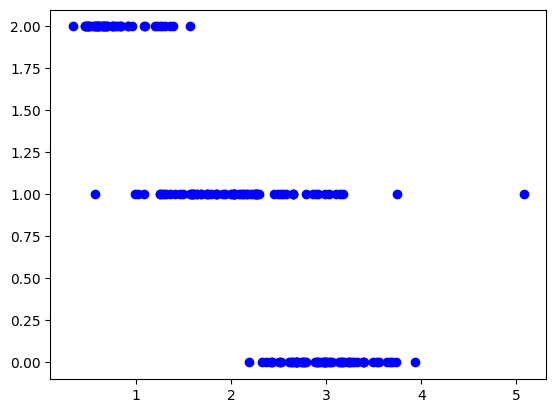

In [21]:
plt.plot(df.flavanoids, y, 'bo')

For each value, we can plot the average target for data:
 - below that value
 - above that value
 - around that value

Please note that for the line "above that value" the more left we go the higher fraction of data is covered. The same with the "below that value"

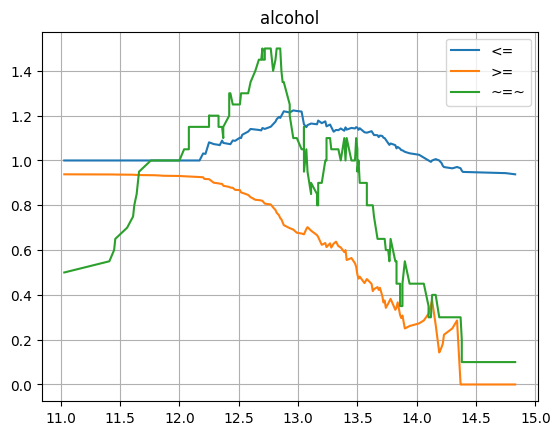

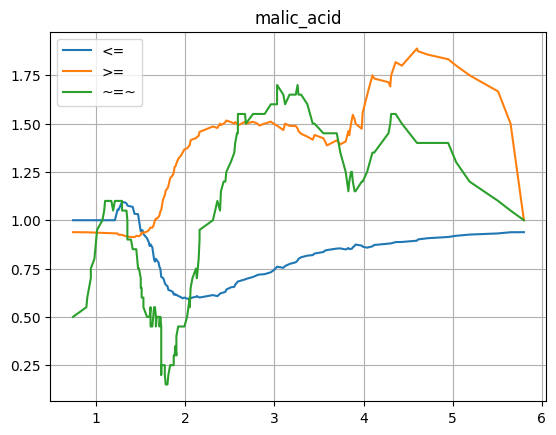

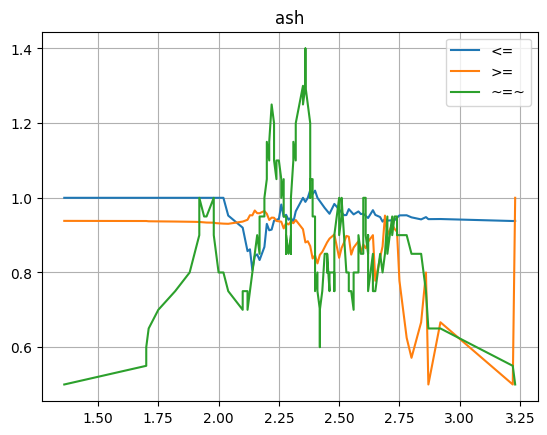

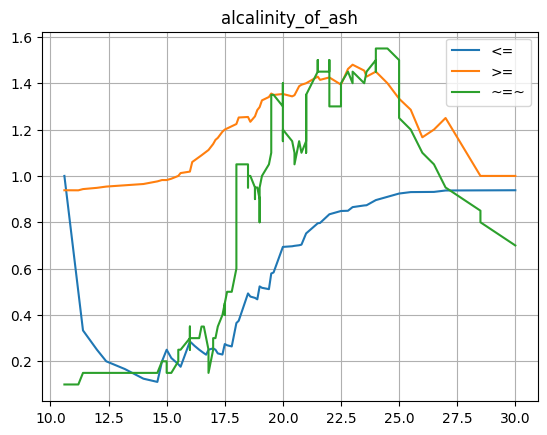

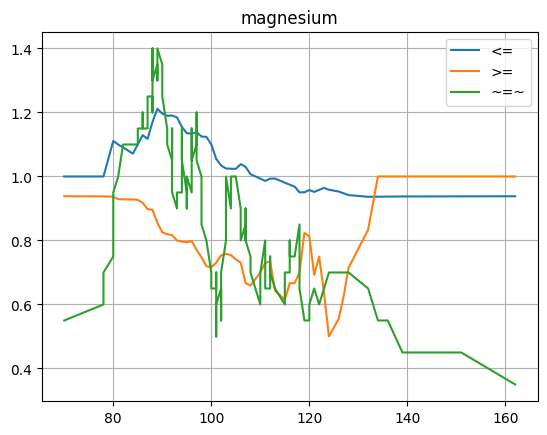

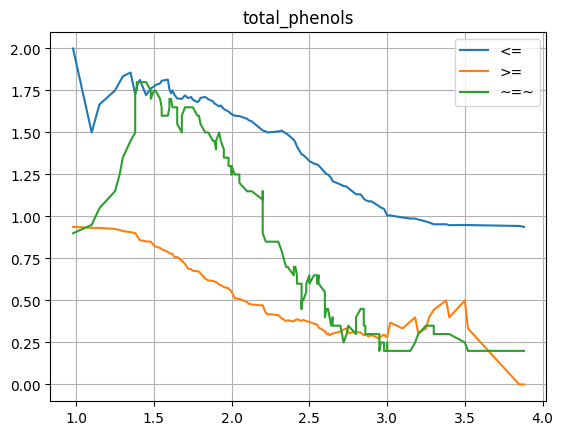

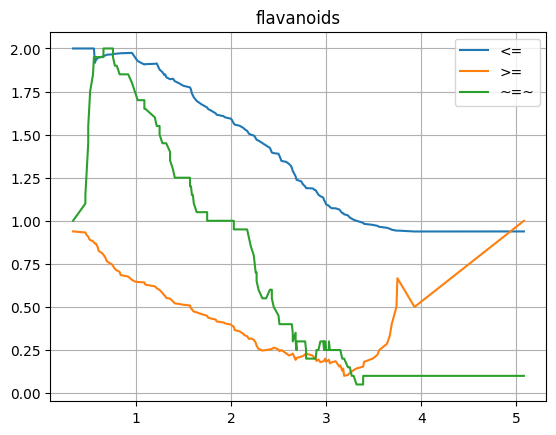

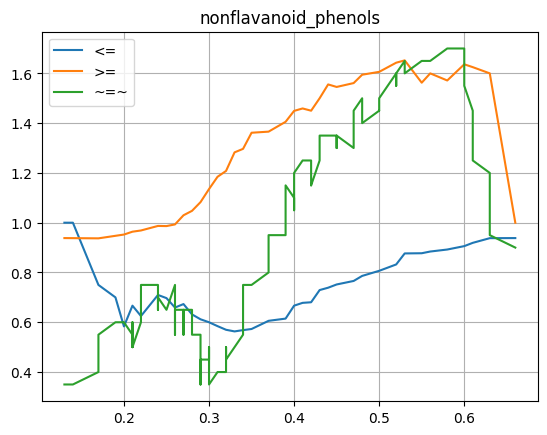

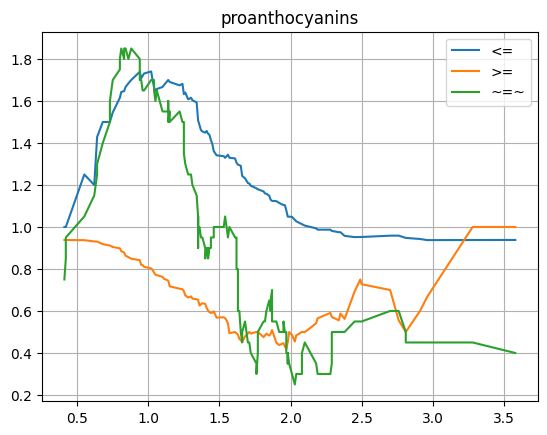

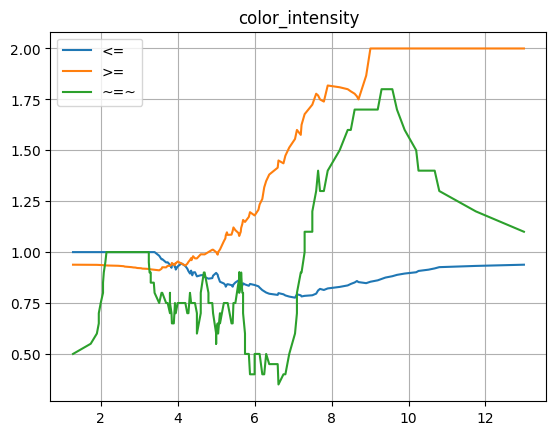

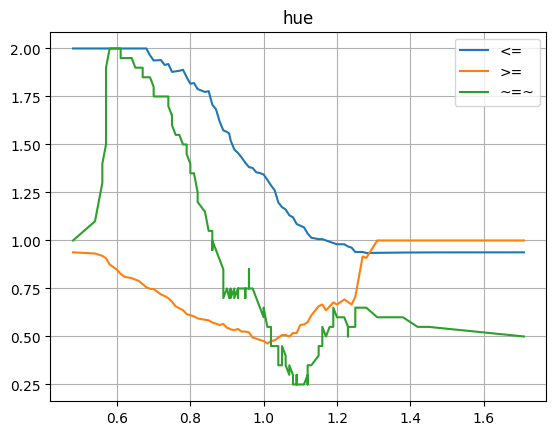

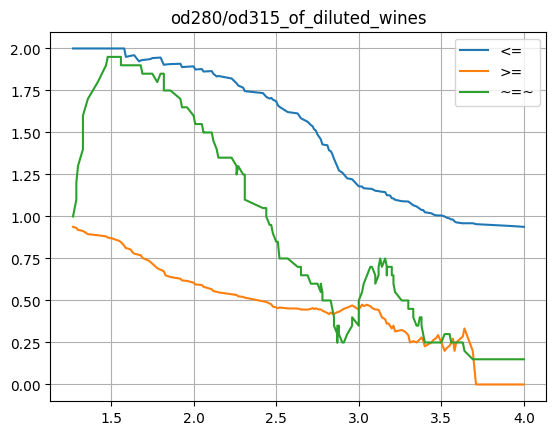

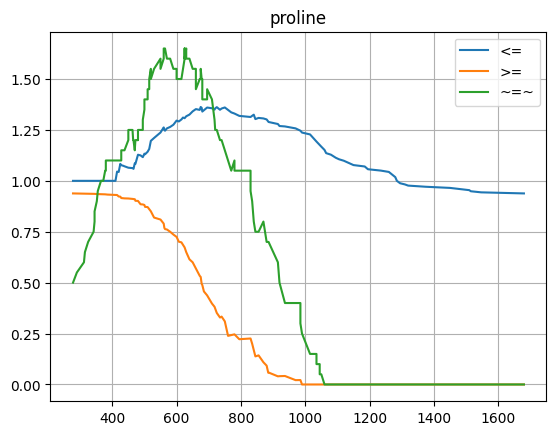

In [22]:
for col in df.columns.drop('target'):
    tmp = df.sort_values(col)
    plt.title(col)
    plt.plot(tmp[col], tmp[col].apply(lambda x: tmp[tmp[col] <= x].target.mean()), label="<=")
    plt.plot(tmp[col], tmp[col].apply(lambda x: tmp[tmp[col] >= x].target.mean()), label=">=")
    plt.plot(tmp[col], np.convolve(np.ones(20)/20, tmp.target, mode='same'), label= "~=~")
    plt.legend()
    plt.grid()
    plt.show()

Ok, let's just train a model. We are not interested in top performance right now so we will skip hyperparameter optimization. Also, we want to find the pattern in the data we have, so we don't split the data into validation and test set.

In [23]:
model = RandomForestRegressor()
x = df.drop('target', axis=1)
y = df.target
model.fit(x, y)

RandomForestRegressor()

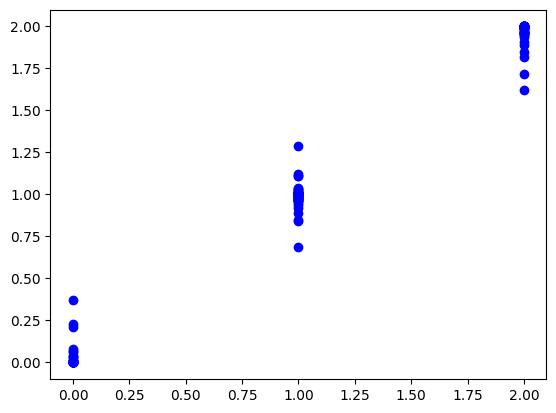

In [24]:
plt.plot(df.target, model.predict(x), 'bo')

Dalex is a python package for model explainability. We will use some of its functions to understand the data and the model better. First, we need to create an explainer model. Since we are not interested in checking the model performance but the relation between the data and the target we will use the whole dataset here. In the first case, we might want to use the testing set.

In [25]:
exp = dx.Explainer(model, x, y)

Preparation of a new explainer is initiated

  -> data              : 178 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 178 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x1543363a0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.933, max = 2.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.37, mean = 0.00551, max = 0.38
  -> model_info        : package sklearn

A new explainer has been created!


In [26]:
fi = exp.model_parts()

The first step will be feature importance. It's a basic analysis where we calculate the global impact of a feature. The idea in dalex default approach is to measure how much the model performance is worsening after removing this feature. Of course, it would require retraining the model, the optimal set of hyperparameters might be different and it might affect the results. To avoid these problems we do not retrain the model. Instead, we simulate its removal by assigning random values to it. To make it more realistic the values are not completely random, we just shuffle this column in a dataframe, do the prediction, check performance and repeat these steps multiple times.

In [27]:
fi.plot()

Another useful tool is a partial dependency plot. For a given feature we observe what's the average output of our model for different values of this feature. For each considered value we set this value for each row in our dataframe and calculate an average prediction.

In [28]:
exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 13/13 [00:00<00:00, 65.43it/s]



We can also create similar plots for single rows. Here for each column, we present what would be the output from the model assuming we keep all remaining values and change the value of this one selected feature.

In [29]:
exp.predict_profile(x.iloc[[15,80]]).plot()

Calculating ceteris paribus: 100%|██████████| 13/13 [00:00<00:00, 236.87it/s]


SHAP values are equivalents of Shapley values for the predictive models. It estimates the effect of a particular value of a particular feature for a prediction of a considered row. It's also done by replacing this value with proper sampling and replacing this value and measuring the effect on the prediction.

In [30]:
exp.predict_parts(x.iloc[15], type='shap').plot()

In [31]:
exp.predict_parts(x.iloc[15], type='shap').plot()

The result is based on sampling so the result for the same row can vary

In [32]:
exp.predict_parts(x.iloc[88], type='shap').plot()

In [33]:
exp.predict_parts(x.iloc[88], type='shap').result

variable  contribution         variable_name  \
0          total_phenols = 1.95      0.004045         total_phenols   
1             malic_acid = 2.06      0.001180            malic_acid   
2               proline = 680.0      0.194101               proline   
3             flavanoids = 1.69     -0.170955            flavanoids   
4              magnesium = 84.0      0.009101             magnesium   
..                          ...           ...                   ...   
8             malic_acid = 2.06      0.002643            malic_acid   
9          total_phenols = 1.95      0.002510         total_phenols   
10     alcalinity_of_ash = 21.6      0.001148     alcalinity_of_ash   
11  nonflavanoid_phenols = 0.48      0.000539  nonflavanoid_phenols   
12                   ash = 2.46      0.000530                   ash   

    variable_value  sign                  label  B  
0             1.95   1.0  RandomForestRegressor  1  
1             2.06   1.0  RandomForestRegressor  1  
2           680.00   1.0  RandomForestRegressor  1  
3             1.69  -1.0  RandomForestRegressor  1  
4            84.00   1.0  RandomForestRegressor  1  
..             ...   ...                    ... ..  
8             2.06   1.0  RandomForestRegressor  0  
9             1.95   1.0  RandomForestRegressor  0  
10           21.60   1.0  RandomForestRegressor  0  
11            0.48   1.0  RandomForestRegressor  0  
12            2.46   1.0  RandomForestRegressor  0  

[338 rows x 7 columns]

**Task** For each class find the most representative examples and plot breakdown for them.

Imagine we have a model classifying dogs and cats. Then a good example would be to show e.g. 3 breeds of dogs and the same with cats. Showing 5 golden retrievers although cute is not the best approach.

There isn't a single best way how to approach this task. There are many good solutions. Think about what you want to achieve and then how to do it

In [34]:
#Searching manually - not very good approach
examples1 = df[df['alcohol'] > 14.35]
l = list(examples1.index)
print(l)

examples2 = df[df['proline'] > 1000]
l2 = list(examples2.index)
print(l2)

examples3 = df[(df['alcalinity_of_ash'] < 14.7) & (df['alcalinity_of_ash'] > 11)]
l3 = list(examples3.index)
print(l3)

[3, 6, 8, 13, 14, 46]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 26, 27, 29, 30, 31, 33, 34, 37, 38, 41, 42, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58]
[1, 6, 8, 13, 14, 39, 50, 52]


In [35]:
for el in df['target'].unique():
    df_1c = df[df['target']==el]
    df_1c_features = df_1c.drop(columns=['target'])
    scaler = StandardScaler()
    df_1c_scaled = scaler.fit_transform(df_1c_features)
    kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(df_1c_scaled)
    centroids = kmeans.cluster_centers_
    distances = np.linalg.norm(df_1c_scaled[:, np.newaxis] - centroids, axis=2)
    representative_examples = np.argmin(distances, axis=0)
    print(f"Breakdown for 3 most representative examples for class {el}:")
    for example in representative_examples:
        exp.predict_parts(df_1c_features.iloc[example], type='shap').plot()

Breakdown for 3 most representative examples for class 0:


Breakdown for 3 most representative examples for class 1:


Breakdown for 3 most representative examples for class 2:


There are other approaches that can be used for model explainability.
 - LIME - approximating model locally by a linear model
 - Anchor - approximating model locally by a rule-based model
 - Prototype - justifying a new prediction by showing a similar example from the data (a prototype)
 - Counterfactual Explanation - showing a similar exmaple from the dataset with a different prediction to show what must be changed to change the prediction.

# Task

- take a dataset you want
- perform an exploratory data analysis (data visualization)
- create a sklearn pipeline for data preprocessing
- add new features (one hot encoding for example)
- add predictive model as the last step of the pipeline
- prepare a report with model explainability

Send it to gmiebs@cs.put.poznan.pl within 144 hours after the class is finished. Start the subject of the email with [IR]

Assume your report will be read by a domain expert from the area of the data, in our case a wine expert, without any computer science / data science skills. It means the person will not get much from raw plots and diagrams. Everything has to be explained to be understood.

In [36]:
#1. Dataset Selection
apples=pd.read_csv("apple_quality.csv")
apples=apples.drop(apples.index[-1])
apples['Quality'] = np.where(apples['Quality'] == 'good', 1, 0)
apples['Acidity'] = apples['Acidity'].astype(float)
apples

A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
0        0.0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
1        1.0 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
2        2.0 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3        3.0 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761   
4        4.0  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849   
...      ...       ...       ...        ...          ...        ...       ...   
3995  3995.0  0.059386 -1.067408  -3.714549     0.473052   1.697986  2.244055   
3996  3996.0 -0.293118  1.949253  -0.204020    -0.640196   0.024523 -1.087900   
3997  3997.0 -2.634515 -2.138247  -2.440461     0.657223   2.199709  4.763859   
3998  3998.0 -4.008004 -1.779337   2.366397    -0.200329   2.161435  0.214488   
3999  3999.0  0.278540 -1.715505   0.121217    -1.154075   1.266677 -0.776571   

       Acidity  Quality  
0    -0.491590        1  
1    -0.722809        1  
2     2.621636        0  
3     0.790723        1  
4     0.501984        1  
...        ...      ...  
3995  0.137784        0  
3996  1.854235        1  
3997 -1.334611        0  
3998 -2.229720        1  
3999  1.599796        1  

[4000 rows x 9 columns]

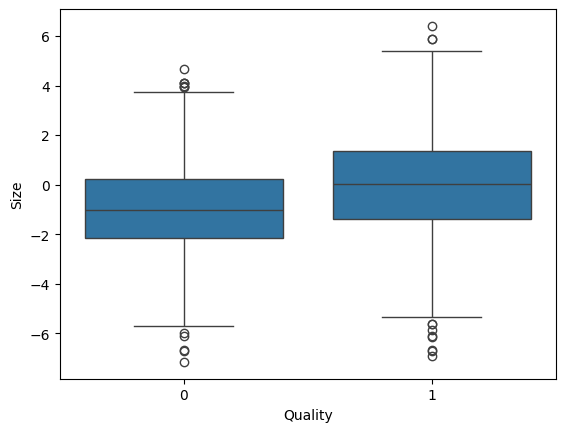

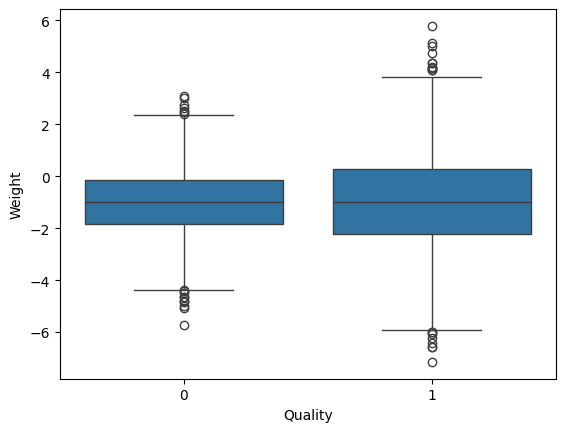

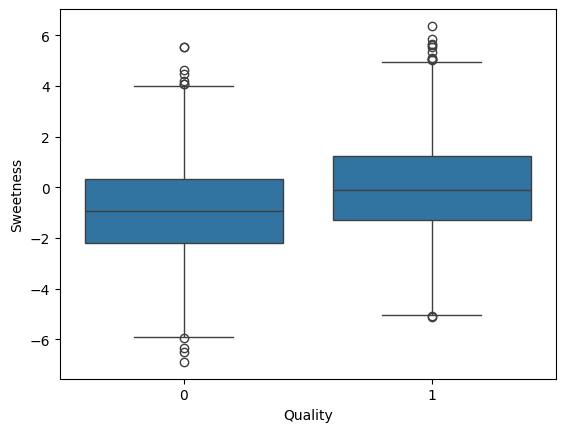

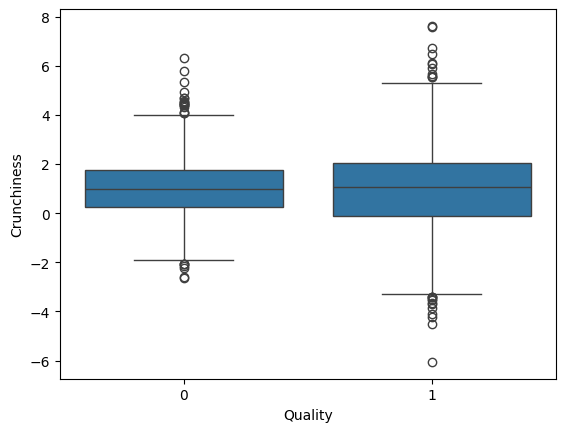

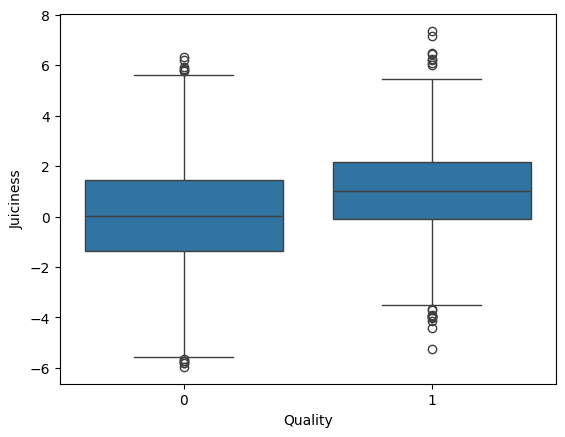

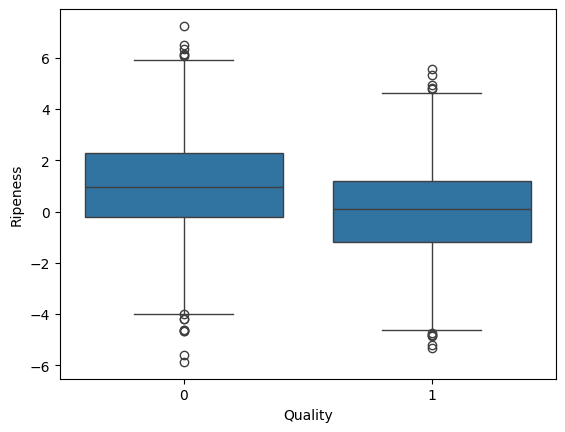

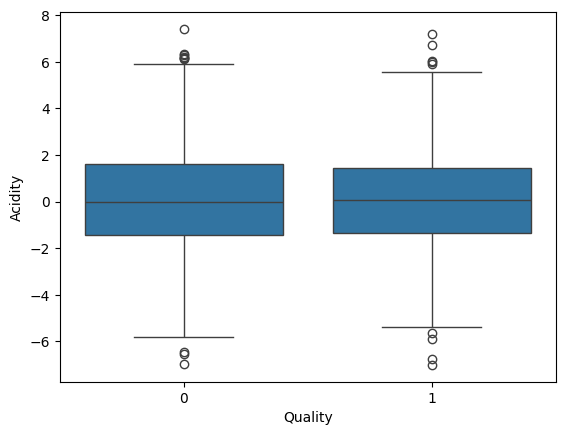

In [37]:
#2a. Exploratory analysis
for col in apples.columns.drop(['Quality','A_id']):
    data=apples[[col,"Quality"]]
    sns.boxplot(x='Quality', y=col, data=data)
    plt.show()

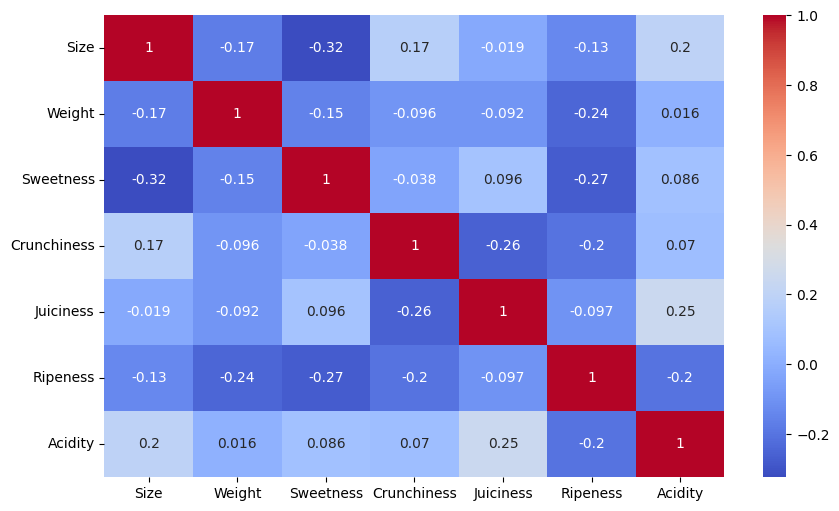

In [38]:
#2b. Exploratory analysis
plt.figure(figsize=(10, 6))
sns.heatmap(apples.drop(columns={"Quality","A_id"}).corr(), annot=True, cmap='coolwarm')
plt.show()

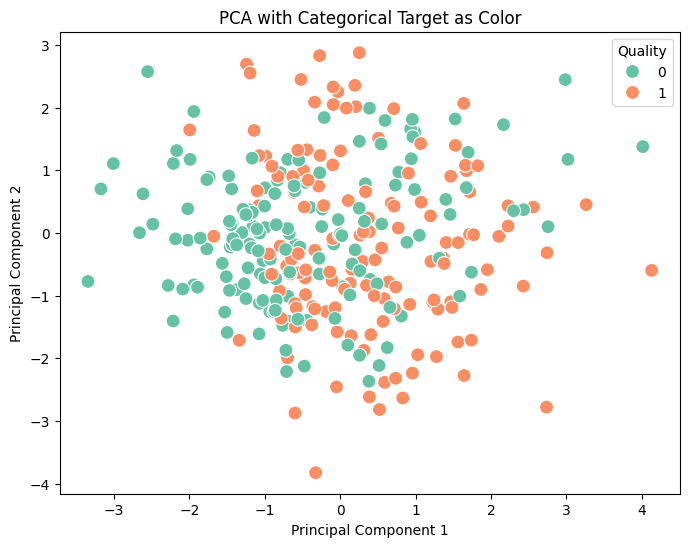

In [39]:
#3. Preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(apples.drop(columns={'Quality'}))

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['Quality'] = apples['Quality']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Quality', palette='Set2', data=pca_df.sample(n=300, random_state=42), s=100)
plt.title('PCA with Categorical Target as Color')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Quality')
plt.show()

In [40]:
apples.columns

Index(['A_id', 'Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness',
       'Ripeness', 'Acidity', 'Quality'],
      dtype='object')

In [41]:
#4. Adding new feature
class CustomBinning(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        bins = ["very low", "low", "medium", "high", "very high"]
        X = pd.DataFrame(X, columns = self.columns)
        for col in X:
            X[col]= pd.qcut(X[col], q = 5, labels = bins)
        return X
    
features_to_bin = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']

pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('binning', CustomBinning(columns = features_to_bin)),  # Custom binning transformer
    ('onehot', OneHotEncoder(sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('binning_pipeline', pipeline, features_to_bin)
])


processed_data = preprocessor.fit_transform(apples)
encoded_feature_names = preprocessor.named_transformers_['binning_pipeline'].named_steps['onehot'].get_feature_names_out(features_to_bin)
processed_df = pd.DataFrame(processed_data, columns=encoded_feature_names)
processed_df

Size_high  Size_low  Size_medium  Size_very high  Size_very low  \
0           0.0       0.0          0.0             0.0            1.0   
1           0.0       1.0          0.0             0.0            0.0   
2           0.0       0.0          1.0             0.0            0.0   
3           0.0       0.0          1.0             0.0            0.0   
4           0.0       0.0          0.0             1.0            0.0   
...         ...       ...          ...             ...            ...   
3995        1.0       0.0          0.0             0.0            0.0   
3996        0.0       0.0          1.0             0.0            0.0   
3997        0.0       0.0          0.0             0.0            1.0   
3998        0.0       0.0          0.0             0.0            1.0   
3999        1.0       0.0          0.0             0.0            0.0   

      Weight_high  Weight_low  Weight_medium  Weight_very high  \
0             0.0         0.0            0.0               0.0   
1             0.0         0.0            0.0               0.0   
2             0.0         0.0            1.0               0.0   
3             0.0         1.0            0.0               0.0   
4             0.0         0.0            1.0               0.0   
...           ...         ...            ...               ...   
3995          0.0         0.0            1.0               0.0   
3996          0.0         0.0            0.0               1.0   
3997          0.0         1.0            0.0               0.0   
3998          0.0         1.0            0.0               0.0   
3999          0.0         1.0            0.0               0.0   

      Weight_very low  ...  Ripeness_high  Ripeness_low  Ripeness_medium  \
0                 1.0  ...            0.0           0.0              1.0   
1                 1.0  ...            0.0           0.0              1.0   
2                 0.0  ...            0.0           1.0              0.0   
3                 0.0  ...            0.0           0.0              0.0   
4                 0.0  ...            0.0           0.0              0.0   
...               ...  ...            ...           ...              ...   
3995              0.0  ...            0.0           0.0              0.0   
3996              0.0  ...            0.0           1.0              0.0   
3997              0.0  ...            0.0           0.0              0.0   
3998              0.0  ...            0.0           0.0              1.0   
3999              0.0  ...            0.0           1.0              0.0   

      Ripeness_very high  Ripeness_very low  Acidity_high  Acidity_low  \
0                    0.0                0.0           0.0          1.0   
1                    0.0                0.0           0.0          1.0   
2                    0.0                0.0           0.0          0.0   
3                    0.0                1.0           1.0          0.0   
4                    0.0                1.0           0.0          0.0   
...                  ...                ...           ...          ...   
3995                 1.0                0.0           0.0          0.0   
3996                 0.0                0.0           1.0          0.0   
3997                 1.0                0.0           0.0          1.0   
3998                 0.0                0.0           0.0          0.0   
3999                 0.0                0.0           1.0          0.0   

      Acidity_medium  Acidity_very high  Acidity_very low  
0                0.0                0.0               0.0  
1                0.0                0.0               0.0  
2                0.0                1.0               0.0  
3                0.0                0.0               0.0  
4                1.0                0.0               0.0  
...              ...                ...               ...  
3995             1.0                0.0               0.0  
3996             0.0                0.0               

In [42]:
y = apples['Quality']
le = LabelEncoder()
y = le.fit_transform(y)

Worth mentioning here is that thanks to preprocessing, we got rid of continous values. We standardized all features, used equi-width approach to discretize them and at the end we used one hot encoding. Now we dont dont deal with numbers but only 0s and 1s in proper column (if size is very low, then size_very_low feature equals 1 and all other features referring to size are set to 0). In other words, we now check if category is very low, if category is (just) low, if category is medium, if category is high or if category is very high

In [43]:
#5a. Splitting data into three subsets
X_train, X_test, y_train, y_test = train_test_split(processed_df, y, test_size=0.2, random_state=42)

best_acc=0
best_model=None
parameters={'depth':None,'min_samples':None}
for max_depth in range(2,21):
    for min_samples_split in range(2,21):
        model = RandomForestClassifier(max_depth=max_depth,min_samples_split=min_samples_split,random_state=42)
        model.fit(X_train,y_train)

        y_pred=model.predict(X_test)
        acc=accuracy_score(y_pred,y_test)
        
        if acc>best_acc:
            best_acc=acc
            best_model=model
            parameters['depth']=max_depth
            parameters['min_samples']=min_samples_split
print(best_acc)


0.87


In [44]:
# #5b. Selecting a model
# model = SVC()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print(accuracy_score(y_pred, y_test))

In [45]:
model = RandomForestClassifier(max_depth=12,min_samples_split=4,random_state=42)

model.fit(X_train,y_train)
y_pred=model.predict(X_test)

acc=accuracy_score(y_pred,y_test)
print(acc)

0.87


## **Report part**  ##

### **dalex library tools - variable importance** ###

In [46]:
#6. Report
exp = dx.Explainer(model, X_test, y_test)
fi = exp.model_parts()
fi.plot()

Preparation of a new explainer is initiated

  -> data              : 800 rows 35 cols
  -> target variable   : 800 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x154336430> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00568, mean = 0.492, max = 0.982
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.859, mean = 0.0067, max = 0.891
  -> model_info        : package sklearn

A new explainer has been created!


Above visualization suggest that the most important features in our model are: 
- Juiciness_very_low
- Size_very_high
- Ripeness_very_high. 

They have the highest contribution in our model and dropping those will deteriorate our model most.

### **dalex library tools - Aggregated Profiles** ###

In [52]:
exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 35/35 [00:02<00:00, 17.02it/s]


First of all, there is no sense in explaining all 35 features one by one because different features have different impact - we will be interested in biggest spike or slide whenever value (class) switches from 0 to 1. One thing to remember - all features were scaled, then discretized and at the end we used one hot encoding to have only 0s and 1s. What does a visualization above tell us?

1. When size is very high (size_very_high is equal to 1) or high, then according to above visualization, average class increases significantly or slightly. This means that an apple having bigger size is more likely to be good quality. On the other hand, when size is very low or low, then quality decreases sharply or slightly. When size is medium, there is almost no improvement (feature gives us no info). This seems obvious - people often prefer bigger apples over small ones.

2. Furthermore, when juiciness is very low, average class decreases sharply. This indicates that apples having very low juiciness are more likely to have class 0, i. e. be of bad quality. Apples having high or very high juiciness have higher average class (tend to be of better quality).

3. When weight is very high, quality of apple increases. When weight is very low, quality increases but not as much. In other cases, difference is not very big.

4. When sweetness is very high, quality of apple increases and when sweetness is very low, quality drops.

5. If crunchiness is very high or very low, quality of apple rises substantially. If it is low, medium or high, quality of apple falls slightly.

6. If ripeness is very high, apple seems to have much lower quality and if it is very low, apple tend to have higher quality.

7. When aciditiy is high or low, average class stays almost the same - this feautre gives us little information about the class. If acidity of apple is very high, quality decreases by a lot. If acidity of apple is very low or medium, average class rises slightly.

Conclusions: Based on Partial Dependancy Plot, we can infer that the best combination of characteristic of apple is: (very) high size, (very) high juiciness, very high weight, very high sweetness, very high crunchiness, very low ripness and medium acidity

One remark: we tak into account only one feature at a time - this means that we can miss very important characteristic of apple - if apple size is very high it does not have to be automatically of good quality (if juiciness is very low and acidity is very high, apple quality is not so obvious)

### **SHAP values - summary_plot** ###

In [53]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

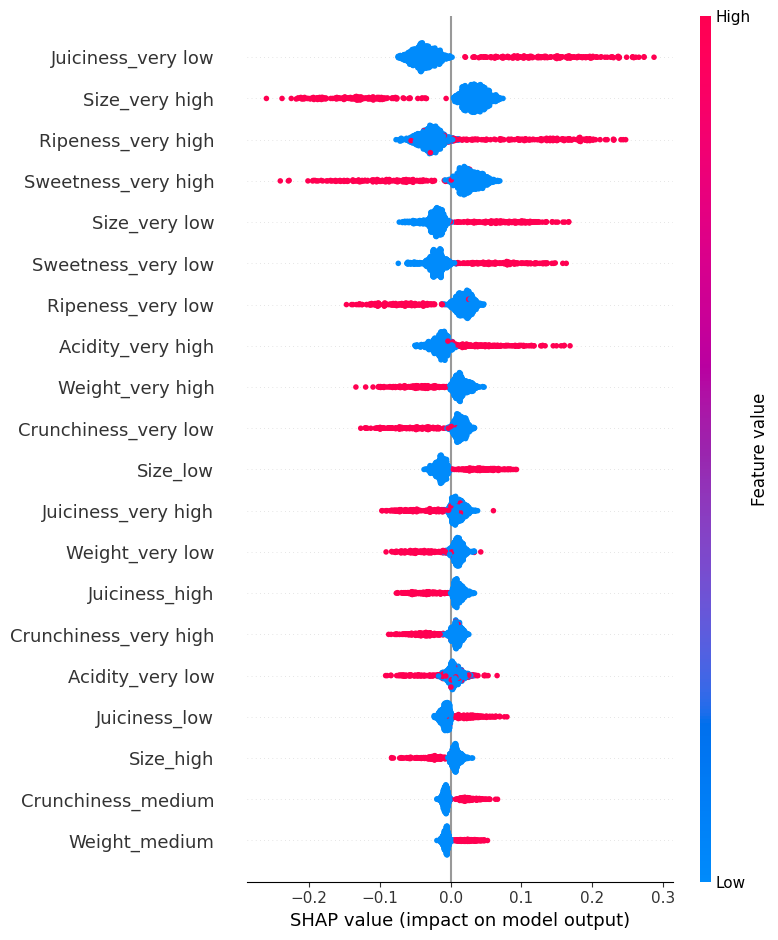

In [54]:
#For class bad (low value -> 0, blue dot) and class good (high value -> 1, red dot)
shap.summary_plot(shap_values[:, :, 0], X_test)

**First of all, there is no need to plot summary_plot() for both classes - we have only two classes so plot for other class will look like mirror reflection!**

The more important feature toward the class (higher feature's contribution), the higher it is on the graph

1. As we can see biggest contribution for the model gives juiciness_very_low; if it is equal to 1, then model is more likely to predict apple of class 0 (bad). If juiciness_very_low = 0, prediction will move towards class 1 (good). Here, answer is simple - when apple has little juices its quality decreases.

2. Another high contribution to the model gives size_very_high feature - if it is equal to 1 it gives negative contribution and SHAP value is less than 0 (0 class is less likely), prediction moves toward class 1 (good) apple. It also works the other way round - if size of apple is very low, more probable class will be 0 class (bad apple). There is explanation for that - consumers prefer big apples over small ones.

3. Third important feature is ripness_very_high. When feature is equal to 1, model is more likely to assign class 0 (bad apple). This is pretty much obvious - people usually don't like too ripe apples because of strange taste.

4. Next observation can be contribution of sweetness_very_high - if feature is equal to 1, SHAP values are negative and feature gives negative contribution. This means that if value of sweetness_very_high is equal to 1, model will probably assign class 1 (good) apple. In other words, people prefer apples that are sweet over bitter ones.

5. According to above plot, another very important characteristic of apple is whether its acidity is very high or not. If acidity is very high, apple probably will be assigned as bad one (red dots move toward right side of the plot). It makes much sense, because people do not like very sour apples.

6. Furthermore, weight of apple. If it is very high, apple is probably of good quality (red dots move towards left). This characteristic is pretty much connected with size of apple.

7. However, there are also features on above plot that give little information. If acidity is very low, SHAP value does not go toward one specific side (in other words, red dots are distributed on both sides of y axis) and we can not say that this feature moves prediction toward one specific side. On the other hand, there are also features with short bars - even though it may give us some information, its contribution for the model is very small (e. g. weight_medium or features that are not listed on the plot)

Conclusions are very similar the ones infered from Partial Dependency Plot.

In [96]:
import random

representative_examples = []
for el in np.unique(y_test):
    print(el)
    df_1c_features = X_test[y_test==el]
    scaler = StandardScaler()
    df_1c_scaled = scaler.fit_transform(df_1c_features)
    kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(df_1c_scaled)
    centroids = kmeans.cluster_centers_
    distances = np.linalg.norm(df_1c_scaled[:, np.newaxis] - centroids, axis=2)
    representative_example = np.argmin(distances, axis=0)
    representative_examples.append(representative_example)
    print(representative_example)
# print(representative_examples)
representative_for_good = random.choice(representative_examples[1])
representative_for_bad = random.choice(representative_examples[0])
print(f"Our representative examples for clas 0: {representative_for_bad} and class 1: {representative_for_good}")

0
[339 287  77]
1
[110 184  60]
Our representative examples for clas 0: 77 and class 1: 110


### **SHAP values - force_plot** ###

**Below there is visualization of SHAP values of class 0 for the apple that belongs to class 0**

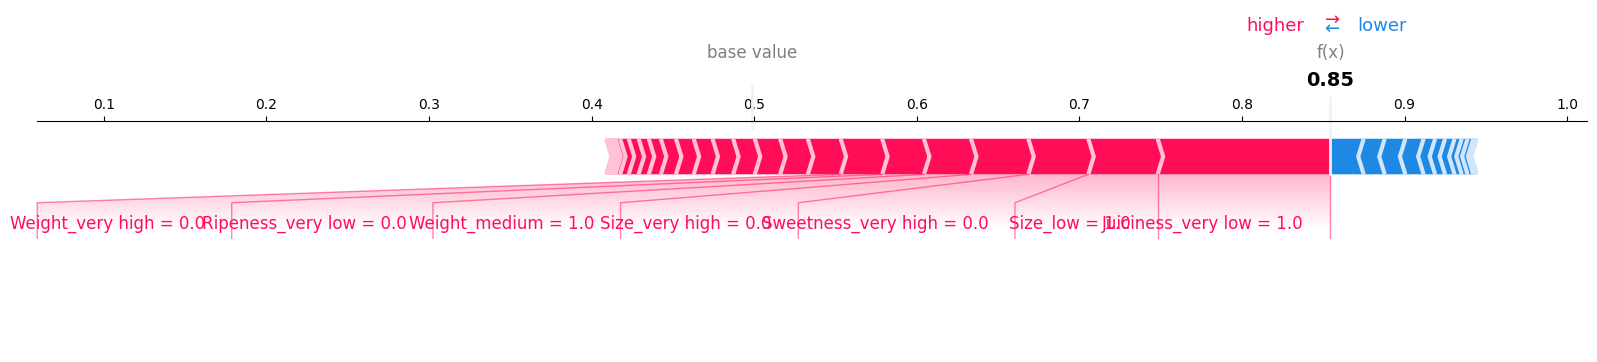

In [97]:
shap.force_plot(explainer.expected_value[0], shap_values[representative_for_bad, :, 0], X_test.iloc[representative_for_bad], matplotlib=True)

The question is why did model assign class 0 to above apple? We look for high SHAP values (i. e. red features with longest bars) - that will increase probability that class 0 is proper class for the apple. In this example most important is that: juiciness is very low, size is low, sweetness is not very high, weight is medium and ripness is not very low. Lets visualize it: this is small apple (size is small and weight is medium), with very little juices and not very sweet. Normal customers probably would also assign bad quality to such apple. 

**Just for some colors, below there is prediction of class 1 for apple that belongs to class 0 (everything is the same but plot is mirror image of the previous one and colors are reversed)**

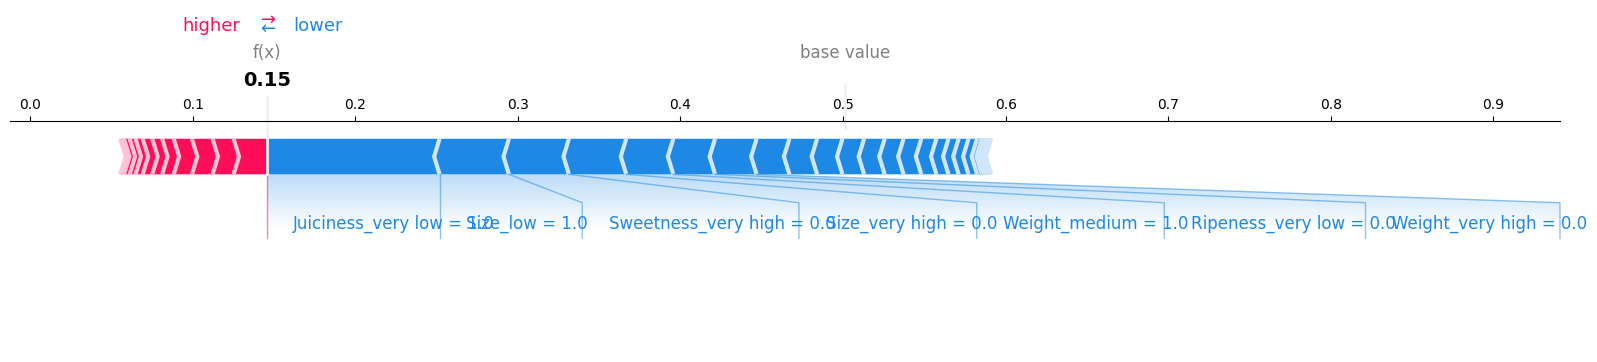

In [99]:
shap.force_plot(explainer.expected_value[1], shap_values[representative_for_bad, :, 1], X_test.iloc[representative_for_bad], matplotlib=True)

This plot does not need much explanation. We can only see that chance of assigning this apple to class 1 is very low (which is consistent with our data).

**Prediction of class 1 for apple that belongs to class 1 by calculating SHAP values**

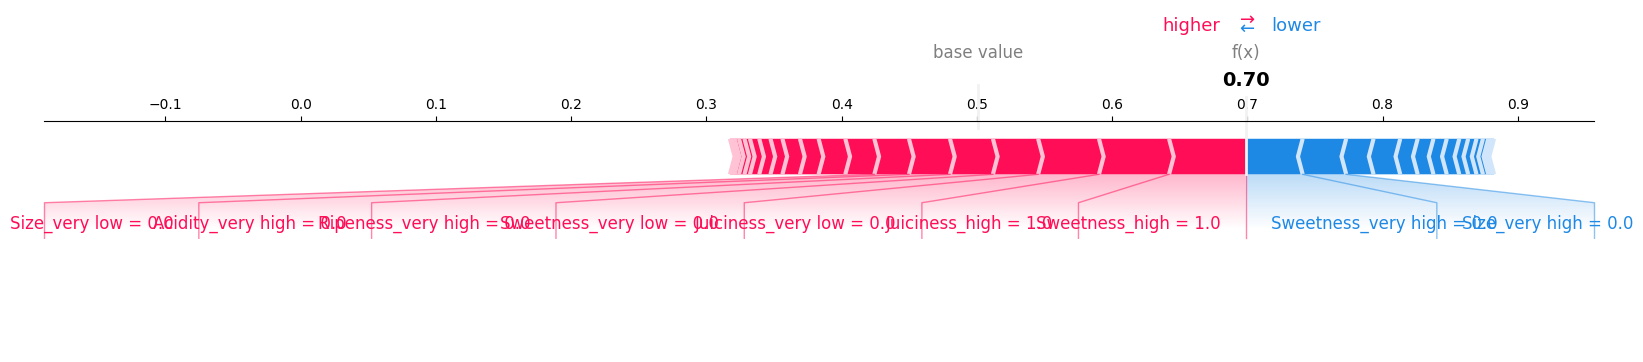

In [98]:
shap.force_plot(explainer.expected_value[1], shap_values[representative_for_good, :, 1], X_test.iloc[representative_for_good], matplotlib=True)

Here we have example of apple that is of good quality. Now the question is why. We again look for long red bars: sweetness is high, juiciness is high, acidity is not very high, and apple is not too ripe. We can also see some blue bars (the longer blue bars, the less probable is the class) - sweetness is not very high and size also is not very high. In reality the apple would look like this: sweet and juicy apple, not too ripe and without very high acidity but also not very big and not very very sweet (just highly sweet). In this case probably, people would agree that this apple was of good quality - maybe it wasn't biggest apple but it had high level of juices and high level of sweetness while not being very sour.

### **LIME** ##

In [100]:
import lime # type: ignore
import lime.lime_tabular # type: ignore

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns, 
                                                   class_names=[0, 1], 
                                                   mode='classification',
                                                   discretize_continuous=True)

i = representative_for_bad  # Instance to explain, lets say 100
exp = explainer.explain_instance(X_test.values[i], model.predict_proba, num_features=35)

# Display the explanation
exp.show_in_notebook(show_table = True)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Above visualization shows similar things to some previous plots, however here we can see contribution of all features. We already analyzed this example in terms of highest contribution, now we can see what has lowest contribution and see exact values. The least important features in this example will be: if acidity is high, if size is medium, if acidity is low, if ripeness is low or medium, if weight is low and if sweetness is medium. This is consistent with second visualization - Partial Dependancy Plot. As we can see, total sum of contributions of last 10 features is 0.04 for class 0 and 0.05 for class 1. In other words, if apple is medium sized or its acidity is high, low or very low is not important for a customer in terms of apples.

### **Anchor** ###

In [102]:
import warnings

warnings.filterwarnings("ignore")

In [103]:
from alibi.explainers import AnchorTabular # type: ignore

explainer = AnchorTabular(predictor=model.predict, feature_names=X_train.columns)
explainer.fit(X_train.values, disc_perc=(25, 50, 75))

explanation = explainer.explain(X_test.iloc[representative_for_bad].values, threshold=0.95)
print (X_test.iloc[representative_for_bad])

print(f'Anchor: {explanation.anchor}')
print(f'Precision: {explanation.precision}')
print(f'Coverage: {explanation.coverage}')

Size_high                0.0
Size_low                 1.0
Size_medium              0.0
Size_very high           0.0
Size_very low            0.0
Weight_high              0.0
Weight_low               0.0
Weight_medium            1.0
Weight_very high         0.0
Weight_very low          0.0
Sweetness_high           0.0
Sweetness_low            1.0
Sweetness_medium         0.0
Sweetness_very high      0.0
Sweetness_very low       0.0
Crunchiness_high         0.0
Crunchiness_low          0.0
Crunchiness_medium       1.0
Crunchiness_very high    0.0
Crunchiness_very low     0.0
Juiciness_high           0.0
Juiciness_low            0.0
Juiciness_medium         0.0
Juiciness_very high      0.0
Juiciness_very low       1.0
Ripeness_high            1.0
Ripeness_low             0.0
Ripeness_medium          0.0
Ripeness_very high       0.0
Ripeness_very low        0.0
Acidity_high             0.0
Acidity_low              1.0
Acidity_medium           0.0
Acidity_very high        0.0
Acidity_very l

Last approach is Anchor algorithm. This will show us some crucial rules (anchors) which if they are fulfilled, model will assign the same value each time with very high probability. In this case we have representative example of bad quality apple (the same as in force plot) and our model predicts with very high precision (99.3 %) that apple with very low level of juices, medium weight and low size will be of bad quality. This makes much sense because such an apple would not be very delicious. Here we don't have 35 features but only 3 rules to fulfill to be sure that apple is of low quality

In [104]:
explanation = explainer.explain(X_test.iloc[representative_for_good].values, threshold=0.95)
print (X_test.iloc[representative_for_good])

print(f'Anchor: {explanation.anchor}')
print(f'Precision: {explanation.precision}')
print(f'Coverage: {explanation.coverage}')

Size_high                0.0
Size_low                 0.0
Size_medium              1.0
Size_very high           0.0
Size_very low            0.0
Weight_high              0.0
Weight_low               1.0
Weight_medium            0.0
Weight_very high         0.0
Weight_very low          0.0
Sweetness_high           1.0
Sweetness_low            0.0
Sweetness_medium         0.0
Sweetness_very high      0.0
Sweetness_very low       0.0
Crunchiness_high         0.0
Crunchiness_low          1.0
Crunchiness_medium       0.0
Crunchiness_very high    0.0
Crunchiness_very low     0.0
Juiciness_high           1.0
Juiciness_low            0.0
Juiciness_medium         0.0
Juiciness_very high      0.0
Juiciness_very low       0.0
Ripeness_high            1.0
Ripeness_low             0.0
Ripeness_medium          0.0
Ripeness_very high       0.0
Ripeness_very low        0.0
Acidity_high             0.0
Acidity_low              1.0
Acidity_medium           0.0
Acidity_very high        0.0
Acidity_very l

In this case (representative example of high quality apple) if apple has high level of juices, its ripeness level is neither very high nor low, acidity is not very high, sweetness is high and size is at least medium (neither low nor very low) apple will be considered to be good quality by the model. This was partially infered from previous parts of this report but also is quite logical - customers would like apple that has: high level of juices, not very high acidity, ripeness level is not very high, sweetness level is high and size is at least medium. Here we have more rules than in previous anchor example but still much less than 35 features.